# Assignment 01: Multi-class Classification 
In this Assignment, you will train a deep model on the CIFAR10 from the scratch using PyTorch.

### Basic Imports

In [33]:
import os
import time
import os.path as osp

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms
import torchvision

import matplotlib.pyplot as plt
from PIL import Image


### Hyperparameters

In [34]:
# random seed
SEED = 1 
NUM_CLASS = 10

# Training
BATCH_SIZE = 128
NUM_EPOCHS = 60
EVAL_INTERVAL=1
SAVE_DIR = './log'

# Optimizer
LEARNING_RATE = 1e-1
# LEARNING_RATE = 1e-2
# LEARNING_RATE = 1e-3
MOMENTUM = 0.9
STEP=5
GAMMA=0.5


### Device

In [35]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


### Dataset


In [36]:
# cifar10 transform
transform_cifar10_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_cifar10_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform_cifar10_train)
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform_cifar10_test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Files already downloaded and verified
Files already downloaded and verified


### Model

In [37]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)  
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)  
        self.fc1 = nn.Linear(8 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 8 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [38]:
model = ConvNet()
model.to(device)

ConvNet(
  (conv1): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=288, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)

### Optimizer

In [39]:
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

### Task 1: per batch training/testing
---

Please denfine two function named ``train_batch`` and ``test_batch``. These functions are essential for training and evaluating machine learning models using batched data from dataloaders.

**To do**: 
1. Define the loss function i.e [nn.CrossEntropyLoss()](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).
2. Take the image as the input and generate the output using the pre-defined SimpleNet.
3. Calculate the loss between the output and the corresponding label using the loss function.

In [40]:
class FocalLoss(nn.Module):
    r"""
        This criterion is a implemenation of Focal Loss, which is proposed in 
        Focal Loss for Dense Object Detection.

            Loss(x, class) = - \alpha (1-softmax(x)[class])^gamma \log(softmax(x)[class])

        The losses are averaged across observations for each minibatch.

        Args:
            alpha(1D Tensor, Variable) : the scalar factor for this criterion
            gamma(float, double) : gamma > 0; reduces the relative loss for well-classiﬁed examples (p > .5), 
                                   putting more focus on hard, misclassiﬁed examples
            size_average(bool): By default, the losses are averaged over observations for each minibatch.
                                However, if the field size_average is set to False, the losses are
                                instead summed for each minibatch.


    """
    def __init__(self, class_num, alpha=None, gamma=2, size_average=True):
        super(FocalLoss, self).__init__()
        if alpha is None:
            self.alpha = Variable(torch.ones(class_num, 1))
        else:
            if isinstance(alpha, Variable):
                self.alpha = alpha
            else:
                self.alpha = Variable(alpha)
        self.gamma = gamma
        self.class_num = class_num
        self.size_average = size_average

    def forward(self, inputs, targets):
        N = inputs.size(0)
        C = inputs.size(1)
        P = F.softmax(inputs)

        class_mask = inputs.data.new(N, C).fill_(0)
        class_mask = Variable(class_mask)
        ids = targets.view(-1, 1)
        class_mask.scatter_(1, ids.data, 1.)
        #print(class_mask)


        if inputs.is_cuda and not self.alpha.is_cuda:
            self.alpha = self.alpha.cuda()
        alpha = self.alpha[ids.data.view(-1)]

        probs = (P*class_mask).sum(1).view(-1,1)

        log_p = probs.log()
        #print('probs size= {}'.format(probs.size()))
        #print(probs)

        batch_loss = -alpha*(torch.pow((1-probs), self.gamma))*log_p 
        #print('-----bacth_loss------')
        #print(batch_loss)


        if self.size_average:
            loss = batch_loss.mean()
        else:
            loss = batch_loss.sum()
        return loss

In [41]:
##################### Write your answer here ##################
# Define the loss function
# criterion = nn.CrossEntropyLoss()
# criterion=nn.L1Loss()
# criterion=FocalLoss()
criterion=FocalLoss(gamma=2,class_num=10)
###############################################################

In [42]:
def train_batch(model, image, target):
    """
    Perform one training batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to train.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated by the defined loss function loss_fn().
    """
    
    ##################### Write your answer here ##################
    output = model(image)
    # loss = criterion(output,target)
    # loss = criterion(F.softmax(output, dim=1),F.one_hot(target,num_classes=10))
    loss = criterion(output,target)
    ###############################################################

    return output, loss

In [43]:

def test_batch(model, image, target):
    """
    Perform one testing batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to evaluate.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated for the batch.
    """

    ##################### Write your answer here ##################
    output = model(image)
    # loss = criterion(output,target)
    # loss = criterion(F.softmax(output, dim=1),F.one_hot(target,num_classes=10))
    loss = criterion(output,target)
    ###############################################################

    return output, loss

### Model Training

In [44]:
training_loss = []
training_acc = []
testing_loss = []
testing_acc = []
lrs=[]

for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)

        # train model
        outputs, loss = train_batch(model, image, target)
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # epoch_loss = running_cls_loss / len(train_set)
    epoch_loss = running_cls_loss / len(train_dataloader)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    training_loss.append(epoch_loss)
    training_acc.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)

            # test model
            outputs, loss = test_batch(model, image, target)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)

        val_loss = val_loss / len(test_dataloader)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        testing_loss.append(val_loss)
        testing_acc.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

    for param_group in optimizer.param_groups:
        lr = param_group['lr']
    lrs.append(lr)


/tmp/ipykernel_296151/2662275098.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  P = F.softmax(inputs)


Epoch: 1/60 Train Loss: 1.4580 Acc: 0.2694
Begin test......
Test Loss: 1.2696 Acc: 0.3403
Epoch: 2/60 Train Loss: 1.3160 Acc: 0.3208
Begin test......
Test Loss: 1.1778 Acc: 0.3739
Epoch: 3/60 Train Loss: 1.3236 Acc: 0.3152
Begin test......
Test Loss: 1.1494 Acc: 0.3865
Epoch: 4/60 Train Loss: 1.2507 Acc: 0.3442
Begin test......
Test Loss: 1.1376 Acc: 0.3942
Epoch: 5/60 Train Loss: 1.2284 Acc: 0.3536
Begin test......
Test Loss: 1.2638 Acc: 0.3491
Epoch: 6/60 Train Loss: 1.1346 Acc: 0.3912
Begin test......
Test Loss: 1.0268 Acc: 0.4390
Epoch: 7/60 Train Loss: 1.0934 Acc: 0.4082
Begin test......
Test Loss: 1.0122 Acc: 0.4446
Epoch: 8/60 Train Loss: 1.0883 Acc: 0.4156
Begin test......
Test Loss: 0.9844 Acc: 0.4568
Epoch: 9/60 Train Loss: 1.0721 Acc: 0.4204
Begin test......
Test Loss: 0.9943 Acc: 0.4469
Epoch: 10/60 Train Loss: 1.0619 Acc: 0.4272
Begin test......
Test Loss: 1.0594 Acc: 0.4359
Epoch: 11/60 Train Loss: 0.9841 Acc: 0.4618
Begin test......
Test Loss: 0.8783 Acc: 0.5035
Epoch: 1

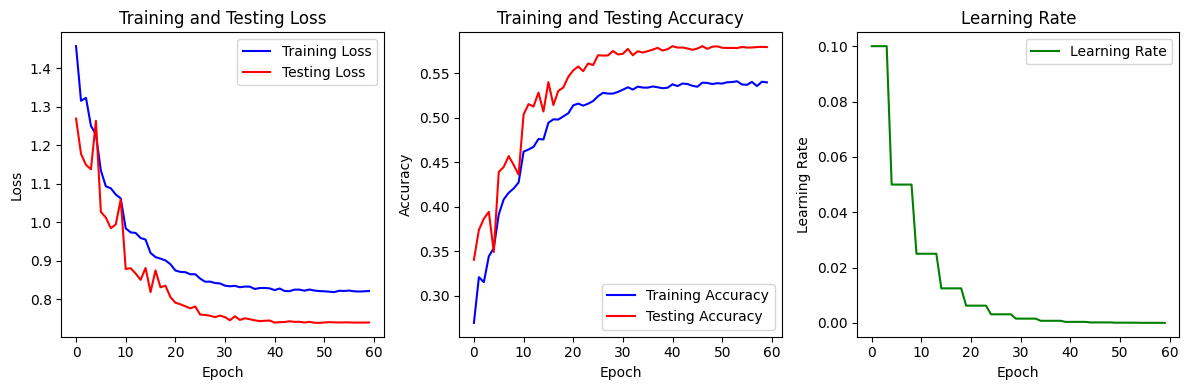

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.plot(range(NUM_EPOCHS), training_loss, label='Training Loss', color='blue')
plt.plot(range(NUM_EPOCHS), testing_loss, label='Testing Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Testing Loss')

# 绘制训练与测试的准确度随epoch的变化
plt.subplot(132)
plt.plot(range(NUM_EPOCHS), training_acc, label='Training Accuracy', color='blue')
plt.plot(range(NUM_EPOCHS), testing_acc, label='Testing Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Testing Accuracy')

# 绘制学习率随epoch的变化
plt.subplot(133)
plt.plot(range(NUM_EPOCHS), lrs, label='Learning Rate', color='green')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.legend()
plt.title('Learning Rate')

plt.tight_layout()
plt.show()

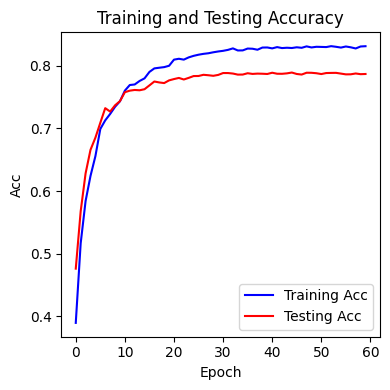

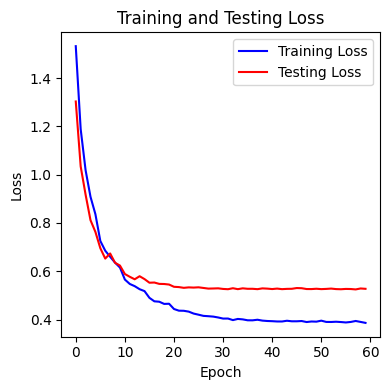

In [13]:
NUM_EPOCHS=60
trainloss=np.load("./save/resnet18/Focal_0.01_0.5_trainacc.npy")
testloss=np.load("./save/resnet18/Focal_0.01_0.5_testacc.npy")

target_path=f"final_save/resnet18"
if not os.path.exists(target_path):
    os.makedirs(target_path)
plt.figure(figsize=(4, 4))
# plt.subplot(131)
plt.plot(range(NUM_EPOCHS), trainloss, label='Training Acc', color='blue')
plt.plot(range(NUM_EPOCHS), testloss, label='Testing Acc', color='red')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.legend()
plt.title('Training and Testing Accuracy')

plt.tight_layout()
plt.savefig(os.path.join(target_path, f"Focal_0.01_0.5_acc.png"))

###############################
trainloss=np.load("./save/resnet18/Focal_0.01_0.5_trainloss.npy")
testloss=np.load("./save/resnet18/Focal_0.01_0.5_testloss.npy")

plt.figure(figsize=(4, 4))
# plt.subplot(131)
plt.plot(range(NUM_EPOCHS), trainloss, label='Training Loss', color='blue')
plt.plot(range(NUM_EPOCHS), testloss, label='Testing Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Testing Loss')

plt.tight_layout()
plt.savefig(os.path.join(target_path, f"Focal_0.01_0.5_loss.png"))

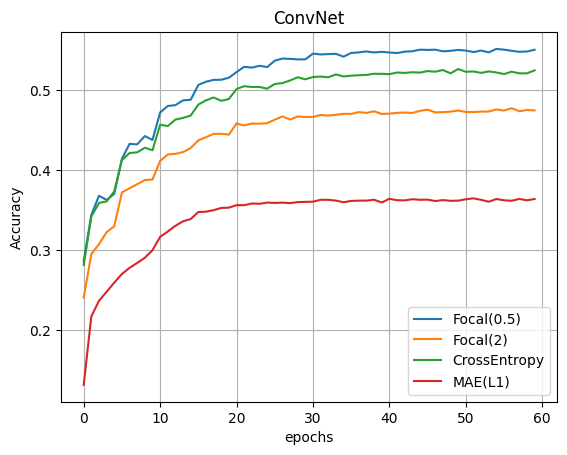

In [18]:
x_data=list(range(60))
y1_data=np.load("./save/vanilla/Focal_0.1_0.5_trainacc.npy")
y2_data=np.load("./save/vanilla/Focal_0.1_2_trainacc.npy")
y3_data=np.load("./save/vanilla/CrossEntropy_0.1_2_trainacc.npy")
y4_data=np.load("./save/vanilla/L1_0.1_2_trainacc.npy")
# 创建一个图形对象
plt.figure()

# 画四条曲线
plt.plot(x_data, y1_data, label='Focal(0.5)')
plt.plot(x_data, y2_data, label='Focal(2)')
plt.plot(x_data, y3_data, label='CrossEntropy')
plt.plot(x_data, y4_data, label='MAE(L1)')

# 设置图例
plt.legend()

# 设置横坐标和纵坐标的标签
plt.xlabel('epochs')
plt.ylabel('Accuracy')

# 设置图形标题
plt.title('ConvNet')

# 显示网格
plt.grid(True)

# 显示图形
plt.show()

In [3]:
loss_list=["CrossEntropy", "L1", "Focal", "Focal(0.5)"]
tt=["train","test"]
for loss_func in loss_list:
    for t in tt:
        if(loss_func=="Focal(0.5)"):
            cur_acc=np.load(f"./save/vanilla/Focal_0.1_0.5_{t}acc.npy")
            print(f"vanilla {loss_func} {t}: {cur_acc[-1]}")
        else:
            cur_acc=np.load(f"./save/vanilla/{loss_func}_0.1_2_{t}acc.npy")
            print(f"vanilla {loss_func} {t}: {cur_acc[-1]}")

vanilla CrossEntropy train: 0.52478
vanilla CrossEntropy test: 0.5515
vanilla L1 train: 0.36398
vanilla L1 test: 0.3765
vanilla Focal train: 0.47464000000000006
vanilla Focal test: 0.5047
vanilla Focal(0.5) train: 0.5504800000000001
vanilla Focal(0.5) test: 0.5817


0.7869
0.7801
0.7769
0.7747
0.7728
0.7691
0.7621
0.7528
0.7495
0.7508
0.7418


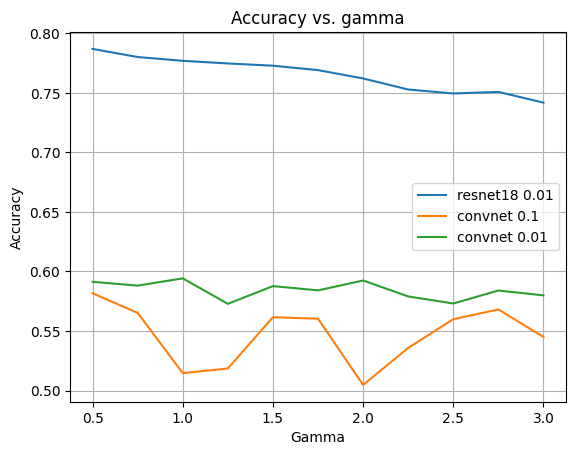

In [25]:
gam=[0.5,0.75,1.0,1.25,1.5,1.75,2,2.25,2.5,2.75,3.0]
y_datas=[]
for i in range(len(gam)):
    y_data=np.load(f"./save/resnet18/Focal_0.01_{gam[i]}_testacc.npy")
    y_datas.append(y_data[-1])
    # print(y_data[-1])
y1_datas=[]
for i in range(len(gam)):
    y1_data=np.load(f"./save/vanilla/Focal_0.1_{gam[i]}_testacc.npy")
    y1_datas.append(y1_data[-1])
y2_datas=[]
for i in range(len(gam)):
    y2_data=np.load(f"./save/vanilla/Focal_0.01_{gam[i]}_testacc.npy")
    y2_datas.append(y2_data[-1])

plt.figure()

# 画四条曲线
plt.plot(gam, y_datas)
plt.plot(gam, y1_datas)
plt.plot(gam, y2_datas)

# 设置图例
plt.legend(["resnet18 0.01","convnet 0.1","convnet 0.01"])

# 设置横坐标和纵坐标的标签
plt.xlabel('Gamma')
plt.ylabel('Accuracy')

# 设置图形标题
plt.title('Accuracy vs. gamma')

# 显示网格
plt.grid(True)

# 显示图形
plt.show()


In [5]:
def find_plateau_epoch(accuracy_list):
    if len(accuracy_list) < 5:
        return None  # 输入列表长度不足5个epoch，无法判断

    max_accuracy = accuracy_list[0]  # 初始化最高准确率
    plateau_start_epoch = None  # 初始化连续下降的epoch起始点
    plateau_length = 0  # 初始化连续下降的长度

    for epoch, accuracy in enumerate(accuracy_list):
        if accuracy > max_accuracy:
            max_accuracy = accuracy
            plateau_start_epoch = None
            plateau_length = 0
        else:
            if plateau_start_epoch is None:
                plateau_start_epoch = epoch
            plateau_length += 1

            if plateau_length >= 5:
                return plateau_start_epoch

    return None  # 没有连续5个epoch没有提升的情况

model_list=["vanilla"]
lr_list=["0.01"]
loss_func_list=["Focal", "CrossEntropy", "L1", "Focal_0.5"]
for i in range(1):
    for loss_func in loss_func_list:
        if((loss_func=="Focal_0.5")):
            trainacc=np.load(f"./save/{model_list[i]}/Focal_{lr_list[i]}_0.5_trainacc.npy")
            testacc=np.load(f"./save/{model_list[i]}/Focal_{lr_list[i]}_0.5_testacc.npy")
            print(f"{model_list[i]} {loss_func} train plateau epoch:{find_plateau_epoch(trainacc)}")
            print(f"{model_list[i]} {loss_func} test plateau epoch:{find_plateau_epoch(testacc)}")
        elif((loss_func!="Focal_0.5")):
            trainacc=np.load(f"./save/{model_list[i]}/{loss_func}_{lr_list[i]}_2_trainacc.npy")
            testacc=np.load(f"./save/{model_list[i]}/{loss_func}_{lr_list[i]}_2_testacc.npy")
            print(f"{model_list[i]} {loss_func} train plateau epoch:{find_plateau_epoch(trainacc)}")
            print(f"{model_list[i]} {loss_func} test plateau epoch:{find_plateau_epoch(testacc)}")

vanilla Focal train plateau epoch:36
vanilla Focal test plateau epoch:29
vanilla CrossEntropy train plateau epoch:28
vanilla CrossEntropy test plateau epoch:26
vanilla L1 train plateau epoch:34
vanilla L1 test plateau epoch:20
vanilla Focal_0.5 train plateau epoch:31
vanilla Focal_0.5 test plateau epoch:29


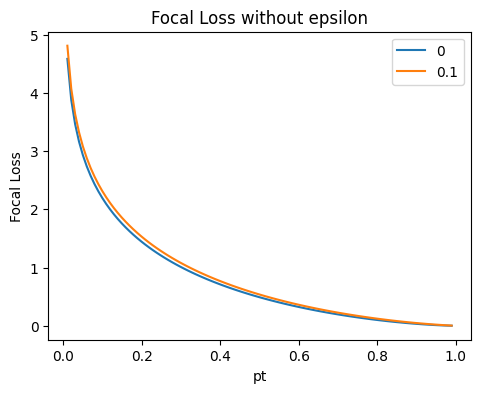

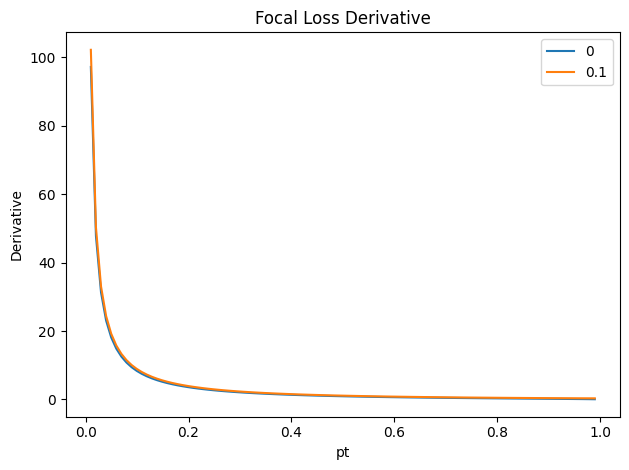

In [33]:
def focal_loss(pt, gamma, epsilon=0):
    return -(1 - pt+epsilon)**gamma * np.log(pt)

def focal_loss_derivative(pt, gamma, epsilon=0):
    return gamma * (1 - pt+epsilon)**(gamma-1) * np.log(pt) + (1 - pt+epsilon)**gamma / pt

# 定义预测概率pt的范围
pt_range = np.linspace(0.01, 0.99, 100)

# 不带epsilon的Focal Loss
gamma = 0.5
focal_loss_values = focal_loss(pt_range, gamma)

# 带epsilon的Focal Loss
epsilon = 0.1
# pt_epsilon = pt_range + epsilon
focal_loss_epsilon_values = focal_loss(pt_range, gamma, epsilon)

# Focal Loss 的导数
focal_loss_derivative_values = focal_loss_derivative(pt_range, gamma)
focal_loss_epsilon_derivative_values = focal_loss_derivative(pt_range, gamma,epsilon)

# 绘制图形
plt.figure(figsize=(12, 4))

# 绘制不带epsilon的Focal Loss
plt.subplot(1, 2, 1)
plt.plot(pt_range, focal_loss_values)
plt.plot(pt_range, focal_loss_epsilon_values)
plt.title('Focal Loss without epsilon')
plt.legend(["0", "0.1"])
plt.xlabel('pt')
plt.ylabel('Focal Loss')

# # 绘制带epsilon的Focal Loss
# plt.subplot(1, 2, 2)
# plt.plot(pt_range, focal_loss_epsilon_values)
# plt.title('Focal Loss with epsilon')
# plt.xlabel('pt')
# plt.ylabel('Focal Loss')

# 绘制Focal Loss的导数
plt.figure()
plt.plot(pt_range, focal_loss_derivative_values)
plt.plot(pt_range, focal_loss_epsilon_derivative_values)
plt.title('Focal Loss Derivative')
plt.legend(["0", "0.1"])
plt.xlabel('pt')
plt.ylabel('Derivative')

plt.tight_layout()
plt.show()


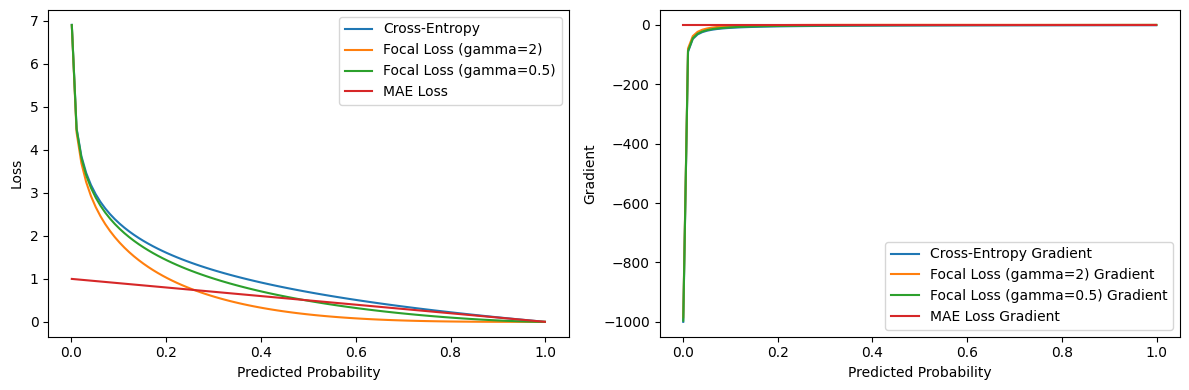

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# 定义预测概率的范围
probs = np.linspace(0.001, 0.999, 100)

# Cross-Entropy 损失
cross_entropy_loss = -np.log(probs)

# Focal Loss (gamma=2)
gamma_2 = 2
focal_loss_2 = -(1 - probs)**gamma_2 * np.log(probs)

# Focal Loss (gamma=0.5)
gamma_0_5 = 0.5
focal_loss_0_5 = -(1 - probs)**gamma_0_5 * np.log(probs)

# MAE Loss
mae_loss = np.abs(probs - 1)

# 计算梯度
cross_entropy_gradient = -1 / probs
focal_loss_2_gradient = -gamma_2 * (1 - probs)**(gamma_2-1) * np.log(probs) - (1 - probs)**gamma_2 / probs
focal_loss_0_5_gradient = -gamma_0_5 * (1 - probs)**(gamma_0_5-1) * np.log(probs) - (1 - probs)**gamma_0_5 / probs
mae_loss_gradient = np.sign(probs - 1)

# 绘制损失图
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(probs, cross_entropy_loss, label='Cross-Entropy')
plt.plot(probs, focal_loss_2, label='Focal Loss (gamma=2)')
plt.plot(probs, focal_loss_0_5, label='Focal Loss (gamma=0.5)')
plt.plot(probs, mae_loss, label='MAE Loss')
plt.xlabel('Predicted Probability')
plt.ylabel('Loss')
plt.legend()

# 绘制梯度图
plt.subplot(1, 2, 2)
plt.plot(probs, cross_entropy_gradient, label='Cross-Entropy Gradient')
plt.plot(probs, focal_loss_2_gradient, label='Focal Loss (gamma=2) Gradient')
plt.plot(probs, focal_loss_0_5_gradient, label='Focal Loss (gamma=0.5) Gradient')
plt.plot(probs, mae_loss_gradient, label='MAE Loss Gradient')
plt.xlabel('Predicted Probability')
plt.ylabel('Gradient')
plt.legend()

plt.tight_layout()
plt.show()

### Task 2: Instance inference
---
The task is to visualizes an image along with model prediction and class probabilities.

**To do**: 
1. Calculate the prediction and the probabilities for each class.
         

In [46]:
inputs, classes = next(iter(test_dataloader))
input = inputs[0]

In [47]:
##################### Write your answer here ##################
# input: image, model
# outputs: predict_label, probabilities
# predict_label is the index (or label) of the class with the highest probability from the probabilities.
###############################################################
# input=input.to(device)
m=nn.Softmax(dim=1)
probabilities = torch.squeeze(m(model(input.to(device))))
predict_label = torch.argmax(probabilities)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


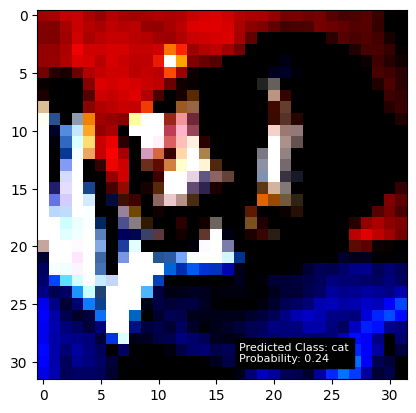

Print probabilities for each class:
airplane: 0.0239
automobile: 0.1688
bird: 0.0280
cat: 0.2413
deer: 0.0432
dog: 0.0581
frog: 0.1865
horse: 0.0362
ship: 0.1277
truck: 0.0864


: 

In [48]:
predicted_class = class_names[predict_label.item()]
predicted_probability = probabilities[predict_label].item()
image = input.cpu().numpy().transpose((1, 2, 0))
plt.imshow(image)
plt.text(17, 30, f'Predicted Class: {predicted_class}\nProbability: {predicted_probability:.2f}', 
            color='white', backgroundcolor='black', fontsize=8)
plt.show()

# Print probabilities for each class
print('Print probabilities for each class:')
for i in range(len(class_names)):
    print(f'{class_names[i]}: {probabilities[i].item():.4f}')